# Arbol de decision

In [1]:
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, auc

import graphviz

In [2]:
y = pd.read_csv('Datasets/tp-2020-2c-train-cols1.csv')

In [3]:
X = pd.read_csv('Datasets/tp-2020-2c-train-cols2.csv')

Llamar a preprocessing para el arbol

In [4]:
y.drop(columns = 'id_usuario',inplace = True)

In [5]:
X.drop(columns = ['id_usuario','nombre','id_ticket','fila'],inplace= True)

In [6]:
X["tipo_de_sala"] = X["tipo_de_sala"].astype("category")
X["genero"] = X["genero"].astype("category")
X["nombre_sede"] = X["nombre_sede"].astype("category")

In [7]:
X["edad"].fillna(X["edad"].mean(), inplace = True)

In [8]:
X.dropna(inplace = True)

In [9]:
y = y.loc[X.index]

In [10]:
X = pd.get_dummies(X, drop_first=True, columns=['tipo_de_sala', 'genero', 'nombre_sede'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Contruccion del arbol

In [12]:
def construir_arbol(X_train, y_train, profundidad_maxima):
    arbol_clasificador = tree.DecisionTreeClassifier(random_state=117, max_depth=profundidad_maxima)
    arbol_clasificador.fit(X_train, y_train)    
    return arbol_clasificador

In [13]:
def predecir(X_test, arbol_clasificador):
    y_pred = arbol_clasificador.predict(X_test)
    return y_pred

In [14]:
def accuracy(y_pred, y_test):
    accuracy_ = pd.Series(np.array(y_test["volveria"]) == y_pred).mean()
    return accuracy_

In [15]:
def graficar_arbol(arbol_clasificador, profundidad_maxima):
    dot_data = tree.export_graphviz(arbol_clasificador, feature_names=X.columns.to_list(),  max_depth = profundidad_maxima) 
    graph = graphviz.Source(dot_data) 
    graph.render("arbol de decision")

In [16]:
def obtener_accuracies_segun_profundidad(profundidades):

    accuracies = []
    profundidades_maximas = []

    for profundidad_maxima in profundidades:
        arbol_clasificador = construir_arbol(X_train, y_train, profundidad_maxima)
        y_pred = predecir(X_test, arbol_clasificador)
        accuracy_ = accuracy(y_pred, y_test)

        accuracies.append(accuracy_)
        profundidades_maximas.append(profundidad_maxima)
        
    return accuracies, profundidades_maximas

In [17]:
def graficar_accuracy_vs_profundidad(accuracy, profundidades):
    plt.subplots(dpi = 120)
    plt.plot(profundidades, accuracies, color='lightblue', linestyle='dashed', linewidth = 2, 
             marker='o', markerfacecolor='blue', markersize=7) 
    plt.xlabel('Profundidad del arbol')
    plt.ylabel('Accuracy sobre train')
    plt.title("Accuracy segun profundidad")

    axes = plt.gca()
    axes.set_ylim([0,1])

In [18]:
accuracies, profundidades = obtener_accuracies_segun_profundidad([1,2,3,4,5,6,7,8,9,10])

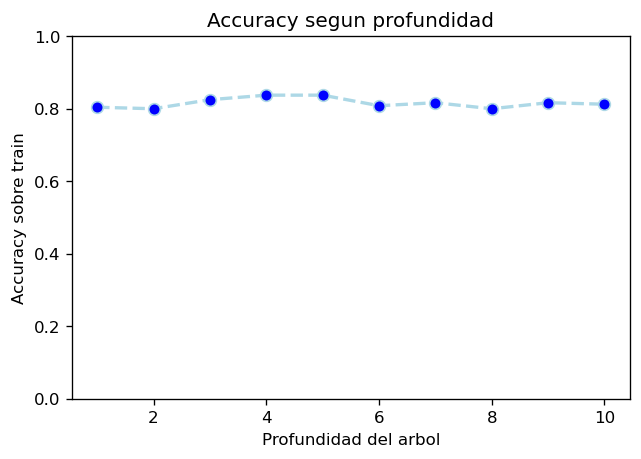

In [19]:
graficar_accuracy_vs_profundidad(accuracies, profundidades)

In [20]:
# Mejor arbol segun accuracy: es el que uso para la matriz de confusion
arbol_clasificador = construir_arbol(X_train, y_train, 4)
y_pred = predecir(X_test, arbol_clasificador)

# Matriz de confusion

Text(69.58333333333333, 0.5, 'Real')

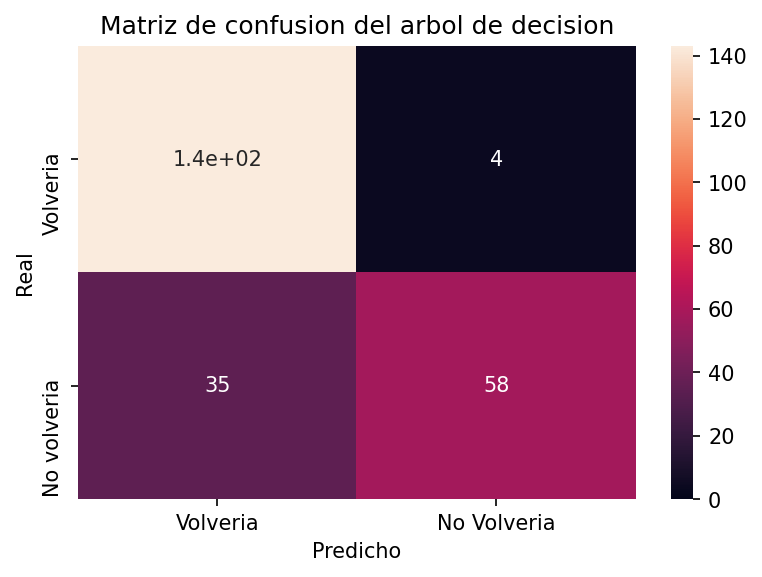

In [21]:
fig, ax = plt.subplots(dpi =150)   
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, vmin = 0, yticklabels=["Volveria","No volveria"], xticklabels=["Volveria", "No Volveria"], ax=ax)
ax.set_title("Matriz de confusion del arbol de decision")
ax.set_xlabel("Predicho")
ax.set_ylabel("Real")

# Metricas

In [22]:
print(classification_report(y_pred, y_test, target_names=["Volveria", "No Voleria"]))

              precision    recall  f1-score   support

    Volveria       0.97      0.80      0.88       178
  No Voleria       0.62      0.94      0.75        62

    accuracy                           0.84       240
   macro avg       0.80      0.87      0.81       240
weighted avg       0.88      0.84      0.85       240



In [23]:
def graficarAUCROC(X_test, X_train, y_test, y_train):

    fpr_cnb_test,tpr_cnb_test,thresholds_cnb_test = roc_curve(y_test, arbol_clasificador.predict_proba(X_test)[:,1])
    fpr_cnb_train,tpr_cnb_train,thresholds_cnb_train = roc_curve(y_train, arbol_clasificador.predict_proba(X_train)[:,1])

    zero_test = np.argmin(np.abs(thresholds_cnb_test))
    zero_train = np.argmin(np.abs(thresholds_cnb_train))

    plt.plot(fpr_cnb_train,tpr_cnb_train,label="ROC Curve Decision Tree Classifier Train")
    plt.plot(fpr_cnb_test,tpr_cnb_test,label="ROC Curve Decision Tree Classifier Test")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot(fpr_cnb_test[zero_test],tpr_cnb_test[zero_test],'o',markersize=10,label="threshold zero test",fillstyle="none",c="k",mew=2)
    plt.plot(fpr_cnb_train[zero_train],tpr_cnb_train[zero_train],'x',markersize=10,label="threshold zero train",fillstyle="none",c="k",mew=2)

    plt.legend(loc=4)

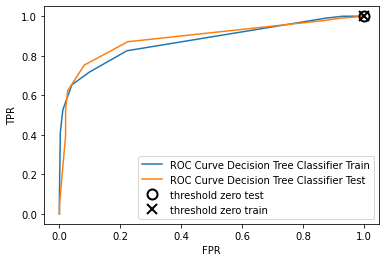

In [24]:
graficarAUCROC(X_test, X_train, y_test, y_train)

# Mejor profundidad por grid search auc roc cross validation

In [25]:
def mejor_profundidad_segun_AUCROC_CV(X, y)

    mejor_auc_roc = 0
    mejor_profundidad = None

    for profundidad in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:

        kf = StratifiedKFold(n_splits=8)
        metricas = []

        for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y)):

            arbol_clasificador = construir_arbol(X.iloc[train_index], y.iloc[train_index], profundidad)        
            y_pred = predecir(X.iloc[test_index], arbol_clasificador)
            auc_roc = roc_auc_score(y.iloc[test_index], y_pred)  
            metricas.append(auc_roc)

        if np.mean(metricas) >= mejor_auc_roc:
            mejor_auc_roc = np.mean(metricas)
            mejor_profundidad = profundidad
            
    return mejor_profundidad, mejor_auc_roc

SyntaxError: invalid syntax (<ipython-input-25-7e0c9ce1a040>, line 1)

In [ ]:
mejor_profundidad, mejor_auc_roc = mejor_profundidad_segun_AUCROC_CV(X, y)